# Climate Analysis and Exploration

In [1]:
#Import  Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float, ForeignKey,func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

In [2]:
#create engine and connections
engine = create_engine(os.path.join("sqlite:///Resources/","hawaii.db"),echo=False)
conn = engine.connect()

In [3]:
#Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.
#create base class instance for reflecting the class
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()

['Measurements', 'Stations']

In [4]:
#set the classes to variables
measurements = Base.classes.Measurements
stations= Base.classes.Stations

In [5]:
#create session
session = Session(engine)

In [6]:
#display the table measurements
first_row = session.query(measurements).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1caacb10390>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [7]:
#display the table stations
first_row = session.query(stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1caacb51748>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

# Precipitation Analysis

In [9]:
#select max date from measurements and extract month from it. subtract 1 from year. retreive value of that year
result = session.execute("SELECT max(date) FROM measurements order by date ").first()
new_d=result[0]
month=new_d.split("-")[1]
date=new_d.split("-")[2]
year=new_d.split("-")[0]
y=int(year)-1
new_date=str(y)+"-"+month+"-"+date
print(new_date)

2016-08-23


In [10]:
#create the query to retreive prcp for previous 12 months
precip_qry = session.query(stations.name,measurements.date, measurements.prcp).filter(measurements.date>=new_date).order_by(measurements.date)
print(precip_qry)

SELECT "Stations".name AS "Stations_name", "Measurements".date AS "Measurements_date", "Measurements".prcp AS "Measurements_prcp" 
FROM "Stations", "Measurements" 
WHERE "Measurements".date >= ? ORDER BY "Measurements".date


In [11]:
#create df from query and calculate the statistics
precip_df = pd.read_sql(precip_qry.statement, precip_qry.session.bind)
precip_df.describe()

,prcp
count,20070.000000
mean,0.175720
std,0.438975
min,0.000000
25%,0.000000
50%,0.030000
75%,0.160644
max,6.700000


In [13]:
#set the index of df as date
new_precip_df=precip_df.set_index("date")

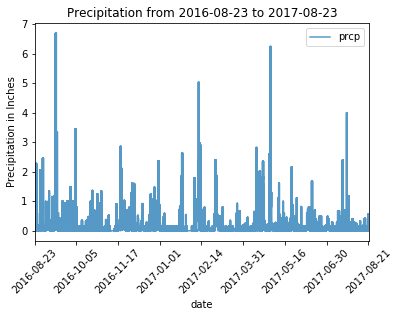

In [16]:
#plot thr graph
plt.figure(figsize=(30,10))
new_precip_df.plot(rot=45,alpha=0.75)
plt.ylabel('Precipitation in Inches')
plt.xlabel("date")
plt.title("Precipitation from "+ str(new_precip_df.index.min())+ " to "+ str(new_precip_df.index.max()))
plt.savefig("images/Precipitation from "+ str(new_precip_df.index.min())+ " to "+ str(new_precip_df.index.max()))
plt.show()

# Station Analysis

In [17]:
#calculate the total # of stations
result = session.execute("SELECT  distinct station FROM measurements ").fetchall()
print("No .of Stations: " ,len(result))

No .of Stations:  9


In [19]:
#find the most active stations.
result = session.execute("SELECT m.station, s.name, count(m.tobs) FROM measurements m inner join stations s where m.station=s.station group by s.station order by count(m.tobs) desc").first()
print("The most active station is %s with %s observations " %(result[1],result[2]))


The most active station is WAIHEE 837.5, HI US with 2772 observations 


In [20]:
#retrieve the data of station with highest observations
station_qry = session.query(measurements.tobs, measurements.station).filter(measurements.date>=new_date).filter(measurements.station==result[0]).order_by(measurements.date)
print(station_qry)

SELECT "Measurements".tobs AS "Measurements_tobs", "Measurements".station AS "Measurements_station" 
FROM "Measurements" 
WHERE "Measurements".date >= ? AND "Measurements".station = ? ORDER BY "Measurements".date


In [21]:
#save to df
station_df = pd.read_sql(station_qry.statement, station_qry.session.bind)
station_df.head()

,tobs,station
0,77,USC00519281
1,77,USC00519281
2,80,USC00519281
3,80,USC00519281
4,75,USC00519281


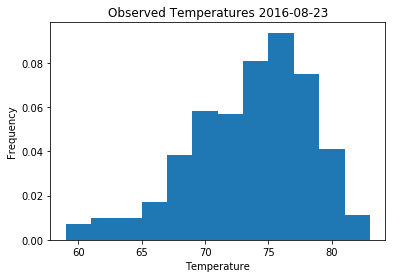

In [22]:
#plot histogram with Bins=12
plt.hist(station_df["tobs"], normed=True, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Observed Temperatures "+ str(new_precip_df.index.min()))
plt.savefig("images/Observed Temperatures "+ str(new_precip_df.index.min()))
plt.show()

# Temperature Analysis